In [ ]:
!pip install datasets transformers evaluate gradio huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Loading a Dataset

In [ ]:
import datasets

ds_builder = datasets.load_dataset_builder('segments/sidewalk-semantic')
ds_builder.info.description, ds_builder.info.features

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


('',
 {'pixel_values': Image(decode=True, id=None),
  'label': Image(decode=True, id=None)})

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 1000
})
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
35


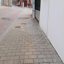

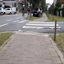

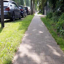

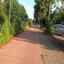

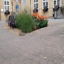

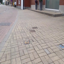

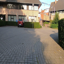

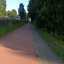

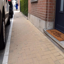

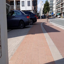

In [ ]:
import numpy as np
dataset = datasets.load_dataset('segments/sidewalk-semantic', split='train')
print(dataset)

num_classes = np.unique(dataset[0]['label'])
for row in dataset:
  local_classes = np.unique(row['label'])
  num_classes = np.unique(np.concatenate((num_classes,local_classes)))
print(num_classes)
print(num_classes.size)
for i in range(10):
  idx = np.random.randint(0,1000)
  display(dataset[idx]['pixel_values'].resize((64,64)))

* **Simplifying the Training Dataset**

In [ ]:
import numpy as np

num_classes = 5

def transform(sample):
    sample["pixel_values"] = sample["pixel_values"].convert("RGB").resize((64,64))
    sample["label"] = sample["label"].resize((64,64), Image.NEAREST)
    collapse_categories = {**{i: 0 for i in range(1, 8)}, 
                            **{i: 1 for i in range(8, 10)}, 
                            **{i: 2 for i in range(10, 18)}, 
                            **{i: 3 for i in range(18, 28)}}
    sample["label"] = np.vectorize(lambda x: collapse_categories.get(x, 4))(np.array(sample["label"]))
    return sample
    
dataset.set_transform(transform)

In [ ]:
dataset = dataset.train_test_split(test_size=0.01)
train_ds = dataset["train"]
test_ds = dataset["test"]
print(train_ds), print(test_ds)

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 990
})
Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 10
})


(None, None)

# Loading a Pretrained Model

In [ ]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model.eval()
model.to(device);

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
extractor = AutoFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# Fine-tuning the Model on the Dataset

In [ ]:
def transform(example_batch):
    inputs = extractor(example_batch['pixel_values'],example_batch['label'])
    return inputs

train_ds.set_transform(transform)
test_ds.set_transform(transform)

In [ ]:
train_subset_ds = train_ds.select(range(10))
train_subset_ds.set_transform(transform)

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

lr = 3e-4
epochs = 10
batch_size = 2

training_args = TrainingArguments(
    "overfit-segmentation-model",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    save_steps=20,
    eval_steps=5,
    logging_steps=1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_subset_ds,
    eval_dataset=test_ds,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss,Validation Loss
5,1.300000,1.232091
10,0.376700,1.236414
15,0.313500,1.051661
20,0.343500,0.987048
25,0.231200,1.184848
30,0.284500,1.193462
35,0.356900,1.109213
40,0.252600,1.095285
45,0.270700,1.073521
50,0.220300,1.060958


***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to overfit-segmentation-model/checkpoint-20
Configuration saved in overfit-segmentation-model/checkpoint-20/config.json
Model weights saved in overfit-segmentation-model/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
***** Running Evaluation *****
  Num examples = 10
  Batch size = 2
Saving model checkpoint to overfit-segmentation-model/checkpoint-40
Configuration saved in overfit-segmentation-model/checkpoint-40/config.json
Model weights saved in overfit-segmentation-model/checkpoint-40/pytorch_model.bin
****

TrainOutput(global_step=50, training_loss=0.36993438184261324, metrics={'train_runtime': 721.2844, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.069, 'total_flos': 1770743188684800.0, 'train_loss': 0.36993438184261324, 'epoch': 10.0})

In [ ]:
print(trainer.state.log_history[0])
print(trainer.state.log_history[1])
print(len(trainer.state.log_history))
print(trainer.state.log_history)

{'loss': 9.6611, 'learning_rate': 0.000294, 'epoch': 0.2, 'step': 1}
{'loss': 7.2835, 'learning_rate': 0.00028799999999999995, 'epoch': 0.4, 'step': 2}
61
[{'loss': 9.6611, 'learning_rate': 0.000294, 'epoch': 0.2, 'step': 1}, {'loss': 7.2835, 'learning_rate': 0.00028799999999999995, 'epoch': 0.4, 'step': 2}, {'loss': 5.1815, 'learning_rate': 0.00028199999999999997, 'epoch': 0.6, 'step': 3}, {'loss': 5.5787, 'learning_rate': 0.000276, 'epoch': 0.8, 'step': 4}, {'loss': 4.1689, 'learning_rate': 0.00027, 'epoch': 1.0, 'step': 5}, {'eval_loss': 4.952329158782959, 'eval_runtime': 1.3739, 'eval_samples_per_second': 7.279, 'eval_steps_per_second': 3.639, 'epoch': 1.0, 'step': 5}, {'loss': 3.4253, 'learning_rate': 0.00026399999999999997, 'epoch': 1.2, 'step': 6}, {'loss': 3.8751, 'learning_rate': 0.000258, 'epoch': 1.4, 'step': 7}, {'loss': 2.9188, 'learning_rate': 0.00025199999999999995, 'epoch': 1.6, 'step': 8}, {'loss': 1.6514, 'learning_rate': 0.00024599999999999996, 'epoch': 1.8, 'step': 

Let's try to plot using only matplotlib for fun

In [ ]:
import matplotlib.pyplot as plt
loss =[]
eval_loss = []
epochs = []
for i in range(1, 11):
  loss.append([d['loss'] for d in trainer.state.log_history if (d['epoch']==float(i) and ('loss' in d))])
  eval_loss.append([d['eval_loss'] for d in trainer.state.log_history if (d['epoch']==float(i)and ('eval_loss' in d))])
loss, eval_loss

([[4.1689],
  [1.8928],
  [2.7236],
  [1.1638],
  [1.4332],
  [1.1888],
  [0.7037],
  [0.8195],
  [0.7508],
  [0.5024]],
 [[4.952329158782959],
  [5.217612266540527],
  [3.909851551055908],
  [3.7500720024108887],
  [3.680245876312256],
  [3.728447675704956],
  [3.610501527786255],
  [3.418505907058716],
  [3.560514450073242],
  [3.6026692390441895]])

[]

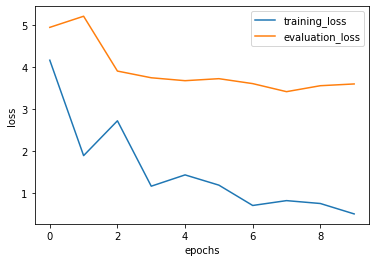

In [ ]:
plt.plot(range(10), loss, label = 'training_loss')
plt.plot(range(10), eval_loss, label = 'evaluation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.plot()

In [ ]:
import numpy as np
import evaluate
from torch import nn

metric = evaluate.load('mean_iou')

In [ ]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_classes,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics


In [ ]:
lr = 3e-4
epochs = 5
batch_size = 1

training_args = TrainingArguments(
    "regular-segmentation-model",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    save_steps=200,
    eval_steps=200,
    logging_steps=20,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 990
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 4950


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
200,0.698700,0.864318,0.337894,0.503764,0.823383,"[0.7934663063797772, 0.7266546120590337, 0.0, 0.031206377194915876, 0.13814452803250782]","[0.9775371727155983, 0.8394692437490413, nan, 0.05085608237547893, 0.14719304917649123]"
400,0.775600,1.255678,0.331114,0.491931,0.822875,"[0.7801702887631914, 0.7360185503721541, 0.0, 0.0, 0.13938165948764453]","[0.9937099130779327, 0.8301270193612036, nan, 0.0, 0.1438873124067519]"
600,0.923500,1.095174,0.387108,0.608245,0.841241,"[0.7585593403618923, 0.7723089983737963, 0.0, 0.35523225469728603, 0.04943695987429802]","[0.9864717140663749, 0.8263582469343006, nan, 0.5704471982758621, 0.04970306877687739]"
800,0.671000,0.711278,0.466565,0.729581,0.871228,"[0.8160233706395391, 0.8057744754714146, 0.0, 0.5579086163285076, 0.15312054557142457]","[0.9886987161571743, 0.8384556154107601, nan, 0.9308997844827587, 0.16026972471696457]"
1000,0.748300,0.906403,0.633256,0.812957,0.870390,"[0.8212428123984746, 0.752184404654592, nan, 0.519067832439837, 0.440528074170838]","[0.9211050458666912, 0.854593962143839, nan, 0.9187320402298851, 0.557396951701138]"
1200,0.610100,0.816062,0.499174,0.781194,0.865127,"[0.8354035247447487, 0.8032596887249284, 0.0, 0.5748483107744229, 0.2823575966289491]","[0.9316368730697252, 0.8484385010331791, nan, 0.9585278975095786, 0.3861714887517187]"
1400,0.697300,0.895380,0.461143,0.695294,0.873014,"[0.8295360268339028, 0.8047378895854945, 0.0, 0.2973295459604819, 0.37411336388174]","[0.9869050861968323, 0.8586349404004584, nan, 0.49974556992337166, 0.4358891846824445]"
1600,0.566900,0.795837,0.588779,0.754439,0.873219,"[0.8792663910677572, 0.756491300055136, nan, 0.3208179530971664, 0.39854039375424305]","[0.9206203766269143, 0.8872706929067071, nan, 0.5229136733716475, 0.6869496533364537]"
1800,0.688300,0.881952,0.502800,0.816141,0.871917,"[0.8546888612528015, 0.8126761040081907, 0.0, 0.43135702138155757, 0.4152762237332317]","[0.90931732391825, 0.8666477175315593, nan, 0.9945821360153256, 0.4940174940760027]"
2000,0.699400,0.796042,0.497917,0.763581,0.885003,"[0.8507604780278376, 0.819513908178818, 0.0, 0.5471639595572924, 0.27214821789581545]","[0.9863638132502203, 0.8563264544965095, nan, 0.9241499042145593, 0.2874820817365357]"


***** Running Evaluation *****
  Num examples = 10
  Batch size = 1
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.7934663063797772, 0.7266546120590337, 0.0, 0.031206377194915876, 0.13814452803250782]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9775371727155983, 0.8394692437490413, nan, 0.05085608237547893, 0.14719304917649123]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to regular-segmentation-model/checkpoint-20

TrainOutput(global_step=4950, training_loss=0.5270291455105097, metrics={'train_runtime': 27041.1194, 'train_samples_per_second': 0.183, 'train_steps_per_second': 0.183, 'total_flos': 8.76517878398976e+16, 'train_loss': 0.5270291455105097, 'epoch': 5.0})

In [ ]:
extractor.push_to_hub("side-walk-segmentation-model")

Feature extractor saved in /tmp/tmpkmfa5sz4/preprocessor_config.json
Uploading the following files to Kavindu99/side-walk-segmentation-model: preprocessor_config.json


CommitInfo(commit_url='https://huggingface.co/Kavindu99/side-walk-segmentation-model/commit/f19b565823956d11798194c6b8d359153392b19f', commit_message='Upload feature extractor', commit_description='', oid='f19b565823956d11798194c6b8d359153392b19f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.push_to_hub("side-walk-segmentation-model")

Configuration saved in /tmp/tmp8l_udloo/config.json
Model weights saved in /tmp/tmp8l_udloo/pytorch_model.bin
Uploading the following files to Kavindu99/side-walk-segmentation-model: config.json,pytorch_model.bin


CommitInfo(commit_url='https://huggingface.co/Kavindu99/side-walk-segmentation-model/commit/b5eb1d754ed639ea64ef773563728eea76162ef9', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='b5eb1d754ed639ea64ef773563728eea76162ef9', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
trainer.state.log_history[0:100]

[{'loss': 0.9157,
  'learning_rate': 0.00029878787878787874,
  'epoch': 0.02,
  'step': 20},
 {'loss': 0.984,
  'learning_rate': 0.0002975757575757575,
  'epoch': 0.04,
  'step': 40},
 {'loss': 0.8119,
  'learning_rate': 0.00029636363636363633,
  'epoch': 0.06,
  'step': 60},
 {'loss': 0.6893,
  'learning_rate': 0.00029515151515151515,
  'epoch': 0.08,
  'step': 80},
 {'loss': 0.5791,
  'learning_rate': 0.0002939393939393939,
  'epoch': 0.1,
  'step': 100},
 {'loss': 0.8719,
  'learning_rate': 0.0002927272727272727,
  'epoch': 0.12,
  'step': 120},
 {'loss': 1.1658,
  'learning_rate': 0.0002915151515151515,
  'epoch': 0.14,
  'step': 140},
 {'loss': 1.0335,
  'learning_rate': 0.00029030303030303027,
  'epoch': 0.16,
  'step': 160},
 {'loss': 0.8193,
  'learning_rate': 0.00028909090909090904,
  'epoch': 0.18,
  'step': 180},
 {'loss': 0.6987,
  'learning_rate': 0.00028787878787878786,
  'epoch': 0.2,
  'step': 200},
 {'eval_loss': 0.8643182516098022,
  'eval_mean_iou': 0.337894364733246

In [ ]:
loss =[]
eval_loss = []
eval_mean_iou=[]
epochs = np.arange(200,4950,200)
for j in epochs:
  loss.append([d['loss'] for d in trainer.state.log_history if (d['step']==j and ('loss' in d))])
  eval_loss.append([d['eval_loss'] for d in trainer.state.log_history if (d['step']==j and ('eval_loss' in d))])
  eval_mean_iou.append([d['eval_mean_iou'] for d in trainer.state.log_history if (d['step']==j and ('eval_mean_iou' in d))])
loss, eval_loss,eval_mean_iou, len(loss)

([[0.6987],
  [0.7756],
  [0.9235],
  [0.671],
  [0.7483],
  [0.6101],
  [0.6973],
  [0.5669],
  [0.6883],
  [0.6994],
  [0.5675],
  [0.6499],
  [0.423],
  [0.4207],
  [0.6619],
  [0.6019],
  [0.357],
  [0.2642],
  [0.3333],
  [0.3526],
  [0.3199],
  [0.2629],
  [0.2215],
  [0.259]],
 [[0.8643182516098022],
  [1.2556779384613037],
  [1.0951744318008423],
  [0.7112783789634705],
  [0.906402587890625],
  [0.8160616755485535],
  [0.8953798413276672],
  [0.7958365678787231],
  [0.8819519877433777],
  [0.7960419654846191],
  [0.7849942445755005],
  [0.8290799856185913],
  [0.7535120844841003],
  [0.8346174955368042],
  [0.923154354095459],
  [0.7316225171089172],
  [0.7960082292556763],
  [0.6598657369613647],
  [0.7902306318283081],
  [0.7917677164077759],
  [0.6683431267738342],
  [0.6939023733139038],
  [0.6780873537063599],
  [0.7201505899429321]],
 [[0.3378943647332469],
  [0.331114099724598],
  [0.38710751066145455],
  [0.46656540160217713],
  [0.6332557809159354],
  [0.49917382417460

[]

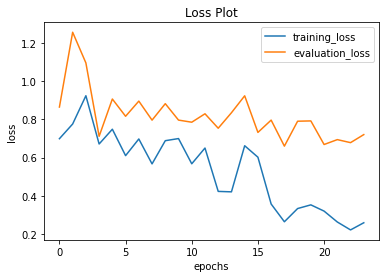

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(24), loss, label = 'training_loss')
plt.plot(range(24), eval_loss, label = 'evaluation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title("Loss Plot")
plt.plot()

[]

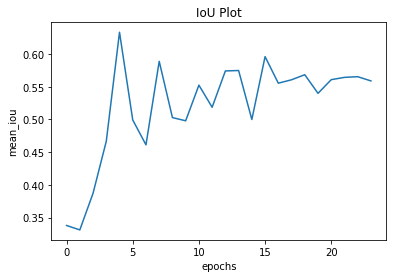

In [ ]:
plt.plot(range(24), eval_mean_iou)
plt.xlabel('epochs')
plt.ylabel('mean_iou')
plt.title("IoU Plot")
plt.plot()

In [ ]:
import matplotlib.pyplot as plt

def classify(im):
  inputs = extractor(images=im, return_tensors="pt").to("cuda")
  outputs = model(**inputs)
  logits = outputs.logits
  classes = logits[0].detach().cpu().numpy().argmax(axis=0)
  colors = np.array([[128,0,0], [128,128,0], [0, 0, 128], 	[128,0,128], [0, 0, 0]])
  return colors[classes]

In [ ]:
import gradio as gr

interface = gr.Interface(fn=classify,
                         inputs='image',
                         outputs='image')

interface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://16890.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f7b5711a110>,
 'http://127.0.0.1:7860/',
 'https://16890.gradio.app')